In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

/home/nakajo/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df_KID1_ml=pd.read_pickle("df_KID1_ml.pkl")
df_KID3_ml=pd.read_pickle("df_KID3_ml.pkl")
df_KID7_ml=pd.read_pickle("df_KID7_ml.pkl")
df_KID9_ml=pd.read_pickle("df_KID9_ml.pkl")
df_KID11_ml=pd.read_pickle("df_KID11_ml.pkl")

In [3]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape,stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1,shape=shape)
    return tf.Variable(initial)

def MakeInputData(df_KID, KID_NAME):
    input_current_state=df_KID[['CPU_utilization','FAN (%)', 'CPU_temperature(degC)', 'PS']].reset_index()
    input_job=df_KID[KID_NAME+'_jobs'].reset_index()
    Inp_np=np.empty((0, 5), float)
    for i in range(len(df_KID)-1):
        Inp_series=pd.concat([input_current_state.ix[i], input_job.ix[i+1]]).drop('Elapsed time (s)')
        tmp_np=np.array(Inp_series)
        Inp_np=np.append(Inp_np, [tmp_np], axis=0)
    input_data_np=Inp_np
    return input_data_np

def MakeOutputData(df_KID, KID_NAME):
    output_candidates=df_KID[['CPU_temperature(degC)', KID_NAME+'_serve_time']].reset_index()
    Oup_np=np.empty((0,2), float)
    oup_series=output_candidates.drop('Elapsed time (s)', axis=1)
    tmp_np=np.array(oup_series)
    Oup_np=np.append(Oup_np,tmp_np, axis=0)
    output_data_np=Oup_np[1:] # skip the initital state 
    return output_data_np

def ShowGraph(input_data_np, output_data_np, KID_NAME):
    #予測値(y)の算出
    NN_predict=sess.run(y, feed_dict={x:input_data_np, y_: output_data_np})
    plt.plot(NN_predict[256:, 0], label="NN prediction")
    plt.plot(output_data_np[256:, 0], label="Measured data")
    plt.xlabel("Data point (time_scale)")
    plt.ylabel("Temperature (deg C)")
    plt.title("Model_for_"+ KID_NAME)
    plt.legend()
    print("MSE:", mean_squared_error(output_data_np, NN_predict))

def DetermineNeuron(nInput, nOutput):
    #非線形回帰モデル
    # 30分類器 full=connection
    global W_fc1, b_fc1, h_fc1, W_fc2, b_fc2, h_fc2, keep_prob, W_fc3, b_fc3, y
    #第１層
    W_fc1 = weight_variable([nInput,30])
    b_fc1 = bias_variable([30])
    h_fc1 = tf.nn.relu(tf.matmul(x,W_fc1) + b_fc1) #発火の定義，発火関数はrelu

    #第２層
    W_fc2 = weight_variable([30,10])
    b_fc2 = bias_variable([10])
    h_fc2 = tf.nn.relu(tf.matmul(h_fc1,W_fc2) + b_fc2)

    keep_prob = tf.placeholder(tf.float32)  

    #最終層（OutPut）
    W_fc3 = weight_variable([10,nOutput])
    b_fc3 = bias_variable([nOutput])
    y = tf.nn.relu(tf.matmul(h_fc2,W_fc3) + b_fc3)

def DefinePlaceHolder(nInput, nOutput):
    global x, y_, w, b
    x = tf.placeholder(tf.float32, shape=[None, nInput], name = "input")
    #x = tf.placeholder(tf.float32, shape=[nInput], name = "input")
    y_ = tf.placeholder(tf.float32, shape=[None, nOutput], name = "output") 
    #y_ = tf.placeholder(tf.float32, shape=[nOutput], name = "output") 

    w = tf.Variable(tf.zeros([nInput, nOutput]))  #weight
    b = tf.Variable(tf.zeros([nOutput])) #bias
    
def InitiateModel():
    global sess, cross_entropy, train_step
    #y_ = training data , y = predection data 
    cross_entropy = tf.reduce_mean(tf.reduce_sum(tf.square(y - y_)))
    #train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    #sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer()) # Initialize variables
    
def ResetGraph():
    tf.reset_default_graph()  
    
def ShowGraph(input_data_np, output_data_np, KID_NAME, epoch):
    #予測値(y)の算出
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    NN_predict=sess.run(y, feed_dict={x:input_data_np, y_: output_data_np})
    plt.plot(NN_predict[256:, 0], label="NN prediction")
    plt.plot(output_data_np[256:, 0], label="Measured data")
    plt.xlabel("Data point (time_scale)")
    plt.ylabel("Temperature (deg C)")
    plt.title("Model_for_"+ KID_NAME)
    plt.legend()
    print("MSE:", mean_squared_error(output_data_np, NN_predict))
    """
    plt.subplot(1, 2, 2)
    Set=[]
    for i in range(200, epoch, 200):
        Set.append(i)
    plt.plot(Set, losses[1:], linestyle="solid", marker="o", label="NN_predict")
    plt.xlabel("set") 
    plt.ylabel("loss")
    plt.title('NN_learning_process')
    plt.legend(loc ="upper right")
    plt.show()
    print("MSE:", mean_squared_error(output_data_np, NN_predict))
    """

INFO:tensorflow:Restoring parameters from ./KID1_NN_model.ckpt
Model restored.
W_fc1 : [[ 4.05609757e-02  4.12913226e-02  1.15825020e-01  3.55672091e-02
  -6.81313425e-02 -9.25618336e-02 -1.59390904e-02  1.67000636e-01
   3.85458581e-03  1.15505733e-01  2.61417121e-01  8.13795775e-02
  -1.03293657e-01  4.24738862e-02  1.95522849e-02  3.16495970e-02
   1.43752858e-01  1.20482922e-01  1.54359192e-01 -1.18032575e-01
   1.61720052e-01  9.30163488e-02 -3.56769189e-02  1.17470078e-01
  -1.79009717e-02 -7.26871332e-03  1.49061326e-02 -1.50638103e-01
   2.58795857e-01 -6.96134791e-02]
 [ 1.64295301e-01 -5.49242198e-02  7.23556522e-03  5.04003614e-02
  -3.57120000e-02  2.60630099e-04  1.32188618e-01  9.59082916e-02
   2.75508668e-02 -1.65490523e-01  1.90759569e-01 -9.65818241e-02
   1.23923123e-01  1.55903613e-02  7.67775178e-02  2.48819366e-01
  -4.11871225e-02 -5.18623926e-03 -5.25949672e-02 -4.06758487e-02
   2.85260435e-02  4.74316441e-02 -9.37227383e-02  8.15614387e-02
   7.00801751e-03  1

/home/nakajo/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


MSE: 0.3112475118578604


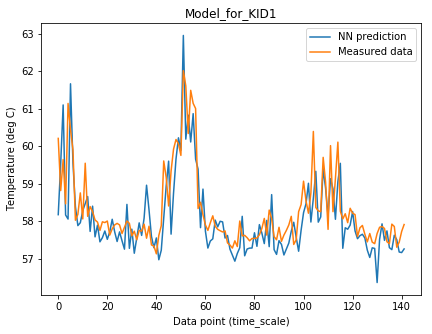

In [4]:
tf.reset_default_graph()
path=os.getcwd()
nInput=5
nOutput=2
epoch=10000
DefinePlaceHolder(nInput, nOutput)
DetermineNeuron(nInput, nOutput)
saver = tf.train.Saver()

with tf.Session() as sess:  # your session object
    InitiateModel()
    saver = tf.train.import_meta_graph(path+'/KID1_NN_model.ckpt.meta')
    saver.restore(sess, tf.train.latest_checkpoint('./'))
    #sess.run(W_fc1)
    print("Model restored.")
    # Check the values of the variables
    print("W_fc1 : %s" % W_fc1.eval())
    print("W_fc2 : %s" % W_fc2.eval())
    input_data_np_KID1=MakeInputData(df_KID1_ml,"KID1")
    output_data_np_KID1=MakeOutputData(df_KID1_ml, "KID1")
    NN_predict=sess.run(y, feed_dict={x:input_data_np_KID1, y_: output_data_np_KID1})    
    NN_predict = y.eval(feed_dict={x:input_data_np_KID1, y_: output_data_np_KID1})
    ShowGraph(input_data_np_KID1, output_data_np_KID1, "KID1", epoch)

In [5]:
os.getcwd()

'/home/nakajo/GT_Kids/Results/ML_data/data_5_ver1/ml_data'